In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [7]:
#import dataset
df_1 =pd.read_csv("KPMG.csv")
df_1.head(10)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,25/02/2017,False,Approved,Solex,Standard,medium,medium,"71,49","$53,62",41245.0
1,2,3,3120,21/05/2017,True,Approved,Trek Bicycles,Standard,medium,large,"2091,47","$388,92",41701.0
2,3,37,402,16/10/2017,False,Approved,OHM Cycles,Standard,low,medium,"1793,43","$248,82",36361.0
3,4,88,3135,31/08/2017,False,Approved,Norco Bicycles,Standard,medium,medium,"1198,46","$381,10",36145.0
4,5,78,787,01/10/2017,True,Approved,Giant Bicycles,Standard,medium,large,"1765,3","$709,48",42226.0
5,6,25,2339,08/03/2017,True,Approved,Giant Bicycles,Road,medium,medium,"1538,99","$829,65",39031.0
6,7,22,1542,21/04/2017,True,Approved,WeareA2B,Standard,medium,medium,"60,34","$45,26",34165.0
7,8,15,2459,15/07/2017,False,Approved,WeareA2B,Standard,medium,medium,"1292,84","$13,44",39915.0
8,9,67,1305,10/08/2017,False,Approved,Solex,Standard,medium,large,"1071,23","$380,74",33455.0
9,10,12,3262,30/08/2017,True,Approved,WeareA2B,Standard,medium,medium,"1231,15","$161,60",38216.0


In [11]:
#checking information of dataset
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           20000 non-null  int64  
 1   product_id               20000 non-null  int64  
 2   customer_id              20000 non-null  int64  
 3   transaction_date         20000 non-null  object 
 4   online_order             19640 non-null  object 
 5   order_status             20000 non-null  object 
 6   brand                    19803 non-null  object 
 7   product_line             19803 non-null  object 
 8   product_class            19803 non-null  object 
 9   product_size             19803 non-null  object 
 10  list_price               20000 non-null  object 
 11  standard_cost            19803 non-null  object 
 12  product_first_sold_date  19803 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 2.0+ MB


In [8]:
#filtering orders_status column by value: approved
Approved = df_1['order_status'] == 'Approved'
df = df_1[Approved]


In [14]:
#drop duplicated
df = df.drop_duplicates()
df = df.dropna(subset=['customer_id'])

In [17]:
#create a function to get month from transaction_date column
def get_month(x): return dt.datetime(x.year, x.month, 1)

In [19]:
#convert transaction_date data type from string to datetime
df["transaction_date"] =  pd.to_datetime(df["transaction_date"], format="%d/%m/%Y")

# Create transaction_date column based on month and store in TransactionMonth
df['order_month'] = df['transaction_date'].apply(get_month) 


In [21]:
#grouping by customer_id and select order_month
customer_group = df.groupby('customer_id')['order_month']

#finding the first transaction.
df['CohortMonth'] = customer_group.transform('min')

In [22]:
#create a function to return year, month, day
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

#get the integers for date parts from the `order_month` column
transcation_year, transaction_month, _ = get_date_int(df, 'order_month')

#get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

In [23]:
#get the difference in years
years_diff = transcation_year - cohort_year

# Calculate difference in months
months_diff = transaction_month - cohort_month

# calculate the difference in months between order_month vs CohortMonth
df['CohortIndex'] = years_diff * 12 + months_diff  + 1 


In [24]:
#count daily active user from each cohort
Customer_group = df.groupby(['CohortMonth', 'CohortIndex'])

#count number of unique customer_id in each group of CohortMonth and CohortIndex
cohort_data = Customer_group['customer_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

 #add column names to the dataframe created above
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'customer_id')


In [25]:
#set cohort_sizes + retention
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [26]:
#create retention index
retention.index = retention.index.strftime('%Y-%m')
retention.index


Index(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12'],
      dtype='object', name='CohortMonth')

In [27]:
#set the figure size
plt.figure(figsize=(16, 10))

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

Text(0.5, 1.0, 'MoM Retention Rate for Customer Transaction Data')

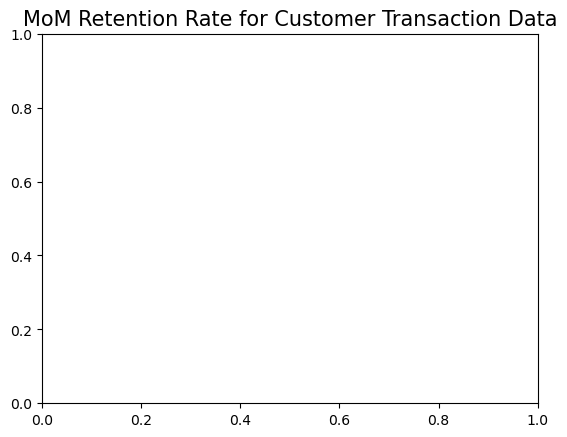

In [28]:
#add title for cohort chart
plt.title('MoM Retention Rate for Customer Transaction Data', fontsize = 15)

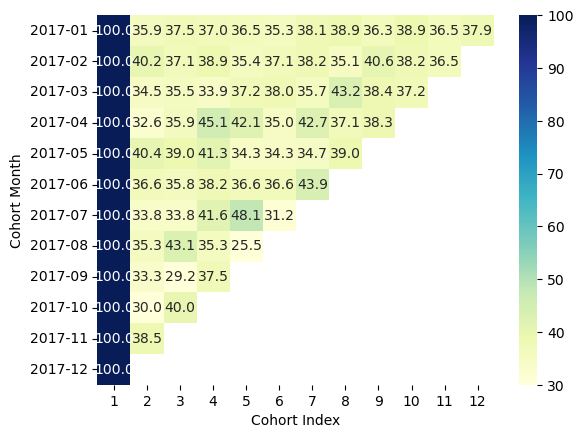

In [30]:
#create the cohort chart
sns.heatmap((retention*100).round(1), annot=True, fmt= '',cmap='YlGnBu', vmin = 30 , vmax = 100)
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation=360)
plt.show()